In [1]:
#include("defArc.jl")

type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

In [2]:
#include("fitTraffic.jl")

## Solve an inverse tarffic problem over polynomials 
## of degree at most d
## optionally use a regularizer from the poly kernel

using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function setUpFitting(deg::Int, c::Float64)

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])
	@defVar(m, Calphas[1:deg+1])

	#build the graham matrix; cf. Ref. [21] (Regularization Networks and Support Vector Machines), page 47
	samples = linspace(0, 1, deg + 1)
	k(x,y) = (c + x*y)^deg
	K = [ k(x,y) for x = samples, y=samples]
	K = convert(Array{Float64, 2}, K)
	#assert(rank(K) == deg+1)
    
	C = chol(K + 1e-6* eye(deg+1))
	for i=1:deg + 1
		@addConstraint(m, polyEval(coeffs, samples[i]) == sum{C[j, i] * Calphas[j], j=1:deg+1})
	end
    
	@defVar(m, reg_term >= 0)
	reg_term_ = QuadExpr(Calphas[:], Calphas[:], ones(deg+1), AffExpr())
    
	@addConstraint(m, reg_term >= reg_term_)
    
	return m, coeffs, reg_term

end

setUpFitting (generic function with 1 method)

In [4]:
function fixCoeffs(m, fcoeffs, coeffs)
	for (fc, c) in zip(fcoeffs, coeffs[:])
		@addConstraint(m, fc == c)
	end
end

fixCoeffs (generic function with 1 method)

In [5]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
	@defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid (generic function with 1 method)

In [6]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
	@addConstraint(m, polyEval(coeffs, 0) <= polyEval(coeffs, sorted_flows[1]))
	for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
    @addConstraint(m, coeffs[1] == 1)  # enforce g(0) = 1
end

addIncreasingCnsts (generic function with 1 method)

In [7]:
#equates the total cost of the network to the true total cost
function normalize(m, coeffs, tot_true_cost::Float64, arcs)
	@addConstraint(m, 
		sum{a.freeflowtime * a.flow * polyEval(coeffs, a.flow / a.capacity), a=values(arcs)} == tot_true_cost)
end

function normalize(m, coeffs, scaled_flow::Float64, cost::Float64)
	@addConstraint(m, polyEval(coeffs, scaled_flow) == cost)
end

function normalize(m, coeffs, scaled_flows::Array{Float64, 1}, avgCost::Float64)
    @addConstraint(m, sum{polyEval(coeffs, f), f=scaled_flows} == avgCost * length(scaled_flows))
end

normalize (generic function with 3 methods)

In [8]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [9]:
############
#Read in demand data
file = open("../temp_files/OD_demand_matrix_Apr_weekday_PM.txt")
demands = Dict{(Int64,Int64), Float64}()
n = 8  # number of nodes
for i in [1:n]
    demands[(i,i)] = 0.0
end
for line in eachline(file)
    OD_demand = split(line, ",")
    key, value = (int(OD_demand[1]),int(OD_demand[2])), float(split(OD_demand[3], "\n")[1])
    demands[key] = value
end
close(file)

In [10]:
demands

Dict{(Int64,Int64),Float64} with 64 entries:
  (3,6) => 1315.275222
  (4,4) => 0.0
  (3,1) => 302.447243
  (4,5) => 278.568958
  (2,4) => 459.387746
  (6,5) => 754.478522
  (8,4) => 383.709803
  (1,2) => 364.030563
  (5,1) => 374.332883
  (3,4) => 636.435156
  (8,2) => 234.682173
  (2,3) => 326.300096
  (2,6) => 663.680693
  (5,4) => 472.954265
  (2,1) => 511.457588
  (2,5) => 581.073471
  (8,5) => 402.014719
  (1,4) => 387.087581
  (2,8) => 213.569741
  (5,8) => 260.003198
  (4,8) => 127.833452
  (7,8) => 188.789153
  (1,1) => 0.0
  (7,7) => 0.0
  (5,7) => 600.509755
  ⋮     => ⋮

In [11]:
using JSON

link_day_minute_Apr_dict = readall("../temp_files/link_day_minute_Apr_dict_JSON_adjusted.json");
link_day_minute_Apr_dict = replace(link_day_minute_Apr_dict, "NaN", 0);

link_day_minute_Apr_dict = JSON.parse(link_day_minute_Apr_dict);

In [12]:
# week_day_Apr_list = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30]

# training set 1
week_day_Apr_list_1 = [2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 16, 17, 18, 19]

# training set 2
week_day_Apr_list_2 = [2, 3, 4, 5, 6, 9, 10, 20, 23, 24, 25, 26, 27, 30]

# training set 3
week_day_Apr_list_3 = [11, 12, 13, 16, 17, 18, 19, 20, 23, 24, 25, 26, 27, 30]

arcs_1 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_1
    arcs_1_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["PM_flow"]
        arcs_1_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_1, arcs_1_)
end

arcs_2 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_2
    arcs_2_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["PM_flow"]
        arcs_2_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_2, arcs_2_)
end

arcs_3 = Dict{(Int, Int), Arc}[]
for j in week_day_Apr_list_3
    arcs_3_ = Dict{(Int, Int), Arc}()
    for i = 0:23
        key = "link_$(i)_$(j)"
        initNode = link_day_minute_Apr_dict[key]["init_node"]
        termNode = link_day_minute_Apr_dict[key]["term_node"]
        capacity = link_day_minute_Apr_dict[key]["PM_capac"]
        freeflowtime = link_day_minute_Apr_dict[key]["free_flow_time"]
        flow = link_day_minute_Apr_dict[key]["PM_flow"]
        arcs_3_[(initNode, termNode)] = Arc(initNode, termNode, capacity, freeflowtime, flow)
    end
    push!(arcs_3, arcs_3_)
end

In [13]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_1); 
sigma = .0

flow_data_1 = Array(Float64, length(arcs_1[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_1[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_1[:, iRun] = [a.flow::Float64 for a in values(arcs_1[iRun])]
end

In [14]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_2); 
sigma = .0

flow_data_2 = Array(Float64, length(arcs_2[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_2[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_2[:, iRun] = [a.flow::Float64 for a in values(arcs_2[iRun])]
end

In [15]:
##########
# Set up demand data and flow data
##########
numData = length(arcs_3); 
sigma = .0

flow_data_3 = Array(Float64, length(arcs_3[1]), numData)

demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs_3[1])
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end


for iRun = 1:numData
    for odpair in keys(demands)
        if ! haskey(demand_data, odpair)
            demand_data[odpair] = [demands[odpair], ]
        else
            push!(demand_data[odpair], demands[odpair])
        end
    end

    #flow_data[:, iRun] = [a.flow::Float64 for a in vArcs]
    flow_data_3[:, iRun] = [a.flow::Float64 for a in values(arcs_3[iRun])]
end

In [16]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [1315.275222,1315.275222,1315.275222,1315.275222,1315.275222,1315.27…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [302.447243,302.447243,302.447243,302.447243,302.447243,302.447243,3…
  (4,5) => [278.568958,278.568958,278.568958,278.568958,278.568958,278.568958,2…
  (2,4) => [459.387746,459.387746,459.387746,459.387746,459.387746,459.387746,4…
  (6,5) => [754.478522,754.478522,754.478522,754.478522,754.478522,754.478522,7…
  (8,4) => [383.709803,383.709803,383.709803,383.709803,383.709803,383.709803,3…
  (1,2) => [364.030563,364.030563,364.030563,364.030563,364.030563,364.030563,3…
  (5,1) => [374.332883,374.332883,374.332883,374.332883,374.332883,374.332883,3…
  (3,4) => [636.435156,636.435156,636.435156,636.435156,636.435156,636.435156,6…
  (8,2) => [234.682173,234.682173,234.682173,234.682173,234.682173,234.682173,2…
  (2,3) => [326.300096,326.300096,326.300096,326.300096,326.300096,

In [17]:
flow_data_3

24x14 Array{Float64,2}:
 4809.79  4300.33  4308.33  4120.52  5008.62  …  4812.05  3545.34  4282.23 
 2384.89  3131.51  2642.63  2099.27  3193.84     3082.46  2167.14  2743.69 
 4106.47  3571.61  3850.44  3582.26  3328.58     3215.12  2980.0   3085.13 
 1590.37  1843.5   1892.91  2003.34  1581.72     1729.59  1197.76  1615.95 
 2868.51  2366.83  1842.96  1480.77  3048.18     2428.02  2089.69  2396.72 
 5405.72  4969.03  4791.13  4313.94  5553.32  …  5441.69  4492.07  5272.96 
 2333.45  2856.29  3123.7   2497.82  2055.75     1732.93  1641.82  2134.98 
 2973.61  3144.45  2786.65  2311.69  3190.74     2735.26  2059.58  2702.44 
 4291.04  4722.17  3498.75  2898.73  4540.75     4763.92  1707.62  4728.43 
 1313.96  2002.14  1771.15  2001.7   1029.42     1161.15  1278.88   897.536
 4406.11  4352.72  4123.65  3382.39  4048.33  …  3795.38  3931.86  3675.75 
 1400.25  2413.67  2003.63  1697.69  1209.0      1819.77  1327.02   911.277
 4615.01  5206.05  3121.76  2490.09  6038.58     5933.95  2433.3

In [18]:
demand_data

Dict{(Int64,Int64),Array{Float64,1}} with 64 entries:
  (3,6) => [1315.275222,1315.275222,1315.275222,1315.275222,1315.275222,1315.27…
  (4,4) => [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
  (3,1) => [302.447243,302.447243,302.447243,302.447243,302.447243,302.447243,3…
  (4,5) => [278.568958,278.568958,278.568958,278.568958,278.568958,278.568958,2…
  (2,4) => [459.387746,459.387746,459.387746,459.387746,459.387746,459.387746,4…
  (6,5) => [754.478522,754.478522,754.478522,754.478522,754.478522,754.478522,7…
  (8,4) => [383.709803,383.709803,383.709803,383.709803,383.709803,383.709803,3…
  (1,2) => [364.030563,364.030563,364.030563,364.030563,364.030563,364.030563,3…
  (5,1) => [374.332883,374.332883,374.332883,374.332883,374.332883,374.332883,3…
  (3,4) => [636.435156,636.435156,636.435156,636.435156,636.435156,636.435156,6…
  (8,2) => [234.682173,234.682173,234.682173,234.682173,234.682173,234.682173,2…
  (2,3) => [326.300096,326.300096,326.300096,326.300096,326.300096,

In [19]:
##########
#Fitting Funcs
##########

function train(indices, lam::Float64, deg::Int, c::Float64, demand_data, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=1e-8)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)


    resids = Variable[]
    
    for i = indices
        #copy the flow data over to the arcs, demand data to demands (slow)
        for (ix, a) in enumerate(vArcs)
            a.flow = flow_data[ix, i]
        end
        for odpair in keys(demands)
            demands[odpair] = demand_data[odpair][i]
        end
    
        #Dual Feasibility
        ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
        
        #add the residual for this data point
        push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))
    end

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    #println(getObjectiveValue(m) - lam * getValue(reg_term) )
    return [getValue(coeffs[i]) for i =1:length(coeffs)]
end

train (generic function with 1 method)

In [20]:
#include("trafficCval.jl")

coeffs_dict_Apr_PM = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_dict_Apr_PM[(deg, c, lam, 1)] = train(1:numData, lam, deg, c, demand_data, flow_data_1, arcs_1[1])
            coeffs_dict_Apr_PM[(deg, c, lam, 2)] = train(1:numData, lam, deg, c, demand_data, flow_data_2, arcs_2[1])
            coeffs_dict_Apr_PM[(deg, c, lam, 3)] = train(1:numData, lam, deg, c, demand_data, flow_data_3, arcs_3[1])
        end
    end
end

In [21]:
outfile = open("../temp_files/coeffs_dict_Apr_PM.json", "w")

JSON.print(outfile, coeffs_dict_Apr_PM)

close(outfile)

In [22]:
coeffs_dict_Apr_PM_ = readall("../temp_files/coeffs_dict_Apr_PM.json")
coeffs_dict_Apr_PM_ = JSON.parse(coeffs_dict_Apr_PM_)

Dict{UTF8String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {1.0,0.025004082977711964,0.017375794870938294,0.007394…
  "(5,0.5,100.0,3)"   => {1.0,0.008964637720086285,0.02334801055049562,0.0253102…
  "(6,1.5,10.0,3)"    => {1.0,0.023486217103947306,0.01798566281064775,0.0095229…
  "(6,2.0,0.1,2)"     => {1.0,0.07674796480592593,-0.12126434647710375,0.0553249…
  "(4,0.5,1000.0,1)"  => {1.0,0.012702260605101209,0.021384492277834493,0.016222…
  "(6,2.0,0.01,1)"    => {1.0,0.10435890637741801,-0.2551442000967191,0.24543897…
  "(8,1.5,0.01,1)"    => {1.0,0.1170587244609041,-0.3249580493863369,0.325293923…
  "(5,1.5,1.0,1)"     => {1.0,0.038276944482115,-0.005157001867634602,-0.0116820…
  "(8,2.5,0.001,2)"   => {1.0,0.15438741111661206,-0.5776572848780641,0.72477296…
  "(4,2.0,0.1,1)"     => {1.0,0.05357725290715764,-0.04761972852441398,0.0073879…
  "(5,1.0,1000.0,2)"  => {1.0,0.01638839835567713,0.01860227796349254,0.01077037…
  "(4,2.0,0.1,2)"     => {1.0,0.05357725290715764,-0.047619

In [23]:
coeffs_dict_Apr_PM_["(8,0.5,100.0,1)"], coeffs_dict_Apr_PM_["(8,0.5,100.0,2)"]

({1.0,-0.0030131072622607818,0.0577898219649197,-0.19558831382204286,0.6207544310979015,-0.9063973663081872,0.9362152176772018,-0.469806830586846,0.10860665283118008},{1.0,-0.0030131072622607818,0.0577898219649197,-0.19558831382204286,0.6207544310979015,-0.9063973663081872,0.9362152176772018,-0.469806830586846,0.10860665283118008})

INFO: Loading help data...


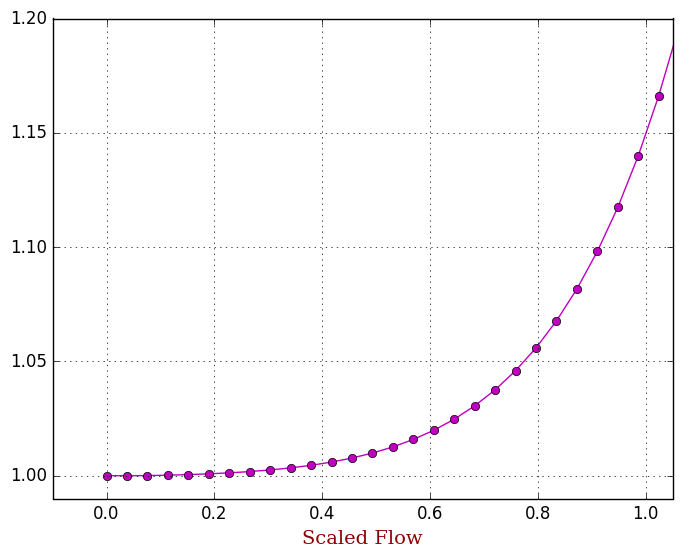

In [24]:
using PyPlot

fcoeffs = coeffs_dict_Apr_PM_["(8,0.5,10000.0,1)"]


xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Apr_PM")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Apr_PM.pdf")